In [224]:

import numpy  as  np
import  pandas  as  pd 
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import pickle

import keras
from keras_applications import densenet
from keras.utils import np_utils
import scipy.io as sio 
import csv
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from PIL import Image

import os
print(os.listdir("../stanford_cars_dataset/"))

['cars_annos.mat', 'cars_test', 'cars_train', 'car_devkit', 'names.csv']


In [225]:
path_base  = '../stanford_cars_dataset'

In [226]:
print(keras.__version__)

2.2.0


In [227]:
class_names = []

with open(path_base + '/names.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile, delimiter=';')
    for row in csvReader:
        class_names.append(row[0])

print(class_names)

['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura Integra Type R 2001', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi A5 Coupe 2012', 'Audi TTS Coupe 2012', 'Audi R8 Coupe 2012', 'Audi V8 Sedan 1994', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi TT Hatchback 2011', 'Audi S6 Sedan 2011', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S4 Sedan 2012', 'Audi S4 Sedan 2007', 'Audi TT RS Coupe 2012', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW Z4 Convertible 2012

In [228]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K

In [229]:
K.set_learning_phase(1)
img_width, img_height = 224, 224
nb_train_samples = 8144
nb_validation_samples = 8041
epochs = 10
batch_size = 32
n_classes = 196

In [230]:
train_data_dir = path_base + '/cars_train/cars_train'
validation_data_dir = path_base + '/cars_test/cars_test'

In [231]:
list = os.listdir(train_data_dir) 
train_files = len(list)
train_files

8144

In [232]:
list = os.listdir(validation_data_dir)
test_files = len(list)
test_files

8041

In [235]:
'''
train_datagen = ImageDataGenerator(
        rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True
)
'''

'\ntrain_datagen = ImageDataGenerator(\n        rescale=1./255,\n        #shear_range=0.2,\n        #zoom_range=0.2,\n        #horizontal_flip=True\n)\n'

In [236]:
'''
test_datagen = ImageDataGenerator(rescale=1. / 255)
'''

'\ntest_datagen = ImageDataGenerator(rescale=1. / 255)\n'

In [237]:
'''
train_generator = train_datagen.flow_from_directory(
    path_base + '/cars_train,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')
'''

"\ntrain_generator = train_datagen.flow_from_directory(\n    path_base + '/cars_train,\n    target_size=(img_width, img_height),\n    batch_size=batch_size,\n    class_mode='categorical')\n"

In [96]:
'''
validation_generator  = test_datagen.flow_from_directory(
    path_base + '/cars_test',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 8041 images belonging to 1 classes.


In [146]:
def get_labels():
    annos = sio.loadmat(path_base+ '/cars_annos.mat')
    _, total_size = annos["annotations"].shape
    print("total sample size is ", total_size)
    labels = np.zeros((total_size, 5))
    for i in range(total_size):
        path = annos["annotations"][:,i][0][0][0].split(".")
        id = int(path[0][8:]) - 1
        for j in range(5):
            labels[id, j] = int(annos["annotations"][:,i][0][j + 1][0])
    return labels
labels = get_labels()

total sample size is  16185


image is 04446.jpg
orignal shape: 492 786
resized shape: 128 192
the label is 55.0


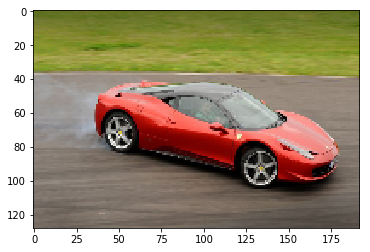

In [150]:
def peek_image(path, idx, labels):
    image_names = os.listdir(path_base+'/' + path + "/" + path)
    im = cv2.imread(path_base+'/' + path + "/" + path + "/" + image_names[idx])[:,:,::-1]
    print("image is", image_names[idx])
    name = image_names[idx].split('.')
    #print(name)
    #print(im.shape)
    w, h, ch = im.shape
    print("orignal shape:" , w, h)
    h_resize = int(128*1.5)
    w_resize = 128
    im = cv2.resize(im,(h_resize,w_resize),interpolation=cv2.INTER_LINEAR)
    w, h, ch = im.shape
    print("resized shape:" , w, h)
    print("the label is " + str(labels[int(name[0]) - 1, 4]))

    plt.imshow(im)
peek_image("cars_train", 4445, labels)   
labels = []

In [152]:
def read_data(path, labels):
    x = []
    y = []
    counter = 0
    
    for file in os.listdir(path_base+'/' + path + "/" + path):
        im = cv2.imread(path_base+'/' + path + "/" + path + "/" + file)[:,:,::-1]
        name = file.split('.')
        w, h, ch = im.shape
        h_resize = int(128*1.5)
        w_resize = 128
        im = cv2.resize(im,(h_resize,w_resize),interpolation = cv2.INTER_LINEAR)
        x.append(im)
        y.append(labels[int(name[0]) - 1,4])
        if counter % 1000 == 0 and counter > 0:
            print("1000 images are loaded.")
        counter += 1
        #print(file, int(name[0]) - 1)
    return np.array(x), np.array(y).reshape([len(y),1])

In [175]:
'''
def load_split_data():
    annos = sio.loadmat(path_base+ '/cars_annos.mat')
    _, total_size = annos["annotations"].shape
    print("total sample size is ", total_size)
    labels = np.zeros((total_size, 5))
    for i in range(total_size):
        path = annos["annotations"][:,i][0][0][0].split(".")
        id = int(path[0][8:]) - 1
        for j in range(5):
            labels[id, j] = annos["annotations"][:,i][0][j + 1][0]
    print("Annotation Loading completed.")
    x_train, y_train = read_data("cars_train", labels)
    print("Loading training data completed.")
    print("training dimension is",x_train.shape)
    x_val_test, y_val_test = read_data("cars_test", labels)
    val_test_size = x_val_test.shape[0]
    print("test and val dimension is",x_val_test.shape)
    print("Loading validation and test data completed.")
      #shuffle and splite vallidation data and test data
    p = np.random.permutation(val_test_size)
    x_val_test = x_val_test[p]
    y_val_test = y_val_test[p]
    x_val = x_val_test[0:int(val_test_size / 2),:,:,:]
    y_val = y_val_test[0:int(val_test_size / 2),:]
    print("validation size is",int(val_test_size / 2))
    x_test = x_val_test[int(val_test_size / 2):val_test_size,:,:,:]
    y_test = y_val_test[int(val_test_size / 2):val_test_size,:]
    print("test size is",val_test_size - int(val_test_size / 2))
    print("Spliting validation and test data completed.")
    return [x_train, x_val, x_test], [y_train, y_val, y_test]
#X, Y = load_split_data()
'''

IndentationError: unexpected indent (<ipython-input-175-7832fd03017e>, line 2)

In [176]:
annos = sio.loadmat(path_base+ '/cars_annos.mat')
_, total_size = annos["annotations"].shape
print("total sample size is ", total_size)
    
labels = np.zeros((total_size, 5))
for i in range(total_size):
    path = annos["annotations"][:,i][0][0][0].split(".")
    id = int(path[0][8:]) - 1
    for j in range(5):
        labels[id, j] = annos["annotations"][:,i][0][j + 1][0]
print("Annotation Loading completed.")
x_train, y_train = read_data("cars_train", labels)
print("Loading training data completed.")
print("training dimension is",x_train.shape)
x_val_test, y_val_test = read_data("cars_test", labels)
val_test_size = x_val_test.shape[0]
print("test and val dimension is",x_val_test.shape)
print("Loading validation and test data completed.")
      #shuffle and splite vallidation data and test data
p = np.random.permutation(val_test_size)
x_val_test = x_val_test[p]
y_val_test = y_val_test[p]
x_val = x_val_test[0:int(val_test_size / 2),:,:,:]
y_val = y_val_test[0:int(val_test_size / 2),:]
print("validation size is",int(val_test_size / 2))
x_test = x_val_test[int(val_test_size / 2):val_test_size,:,:,:]
y_test = y_val_test[int(val_test_size / 2):val_test_size,:]
print("test size is",val_test_size - int(val_test_size / 2))
print("Spliting validation and test data completed.")
#return [x_train, x_val, x_test], [y_train, y_val, y_test]

total sample size is  16185
Annotation Loading completed.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
Loading training data completed.
training dimension is (8144, 128, 192, 3)
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
1000 images are loaded.
test and val dimension is (8041, 128, 192, 3)
Loading validation and test data completed.
validation size is 4020
test size is 4021
Spliting validation and test data completed.


In [198]:
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

In [199]:
'''
generator = ImageDataGenerator(rotation_range=15,
                               width_shift_range=5./32,
                               height_shift_range=5./32)

generator.fit(x_train, seed=0)

In [216]:
batch_size = 32
nb_classes = 196
nb_epoch = 10
depth = 40
nb_dense_block = 3
growth_rate = 12
nb_filter = 12
bottleneck = False
reduction = 0.0
callbacks=32
dropout_rate = 0.0 # 0.0 for data augmentation


In [212]:
def build_model():

    # define the model, use pre-trained weights for image_net
    base_model = densenet.DenseNet121(input_shape=(224, 224, 3),
                             weights='imagenet',
                             include_top=False,
                             pooling='avg')

    x = base_model.output
    predictions = Dense(14, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [165]:
'''
def build_model2():
    base_model = densenet.DenseNet121(input_shape=(img_width, img_height, 3),
                                     weights='imagenet',
                                     include_top=False,
                                     pooling='avg')
    for layer in base_model.layers:
      layer.trainable = True

    x = base_model.output
    x = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    x = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model2
    '''

In [213]:
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

In [214]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr]

In [221]:
def data_genereator(data, batch_size):
        num_rows = int(data.shape[0])
        # Initialize a counter
        counter = 0
        while True:
            for content, label in zip(data['content'], data['label']):
                X_train[counter%batch_size] = transform(content)
                y_train[counter%batch_size] = np.asarray(label)
                counter = counter + 1
                if(counter%batch_size == 0):
                    yield X_train, y_train


In [222]:
training_generator = data_genereator(x_train, batch_size=batch_size)
validation_generator = data_genereator(x_test, batch_size=batch_size)

In [223]:
model.fit_generator(training_generator,
                       steps_per_epoch=8856,
                       validation_data=validation_generator, 
                       epochs=10, 
                       verbose=1,
                       workers=1,
                       use_multiprocessing=False,
                       validation_steps=2216)

Epoch 1/10


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices